#  "Region Growing" and "Superpixels"



First see if basic thresholding will segment the image

In [1]:
import numpy as np
import cv2
import io
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
path = ""


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
uploaded = files.upload()
im = Image.open(io.BytesIO(uploaded['horses2.png'])).convert('RGB')

Saving horses2.png to horses2 (1).png


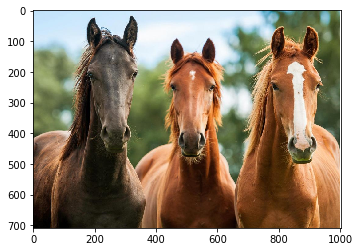

In [3]:
im_arr = np.array(im)
plt.imshow(im_arr)

We start by converting the tomatoes image to greyscale, applying a little Gaussian blur and then using a relatively high threshold to to simplify the image.


In [0]:
#blur = cv2.GaussianBlur(im_arr, (25,25),0) 
blur = cv2.fastNlMeansDenoisingColored(im_arr, None, 20, 20,10,30)


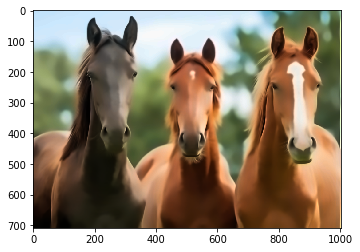

In [18]:
plt.imshow(blur)

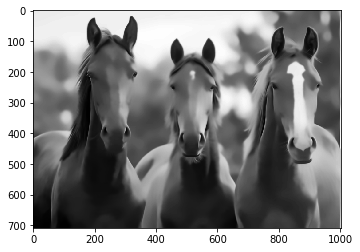

In [19]:
# Convert to grayscale so we can threshold it
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')

In [0]:
m, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#m, thresh = cv2.threshold(gray,220,255,cv2.THRESH_BINARY_INV)


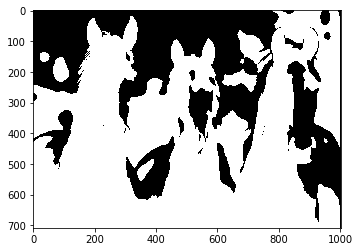

In [21]:
plt.imshow(thresh, cmap='gray')

# Prepare the marker image
.

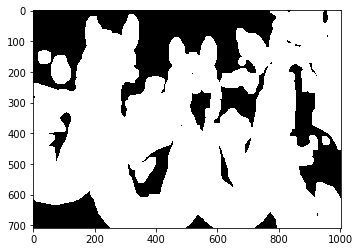

In [22]:
#  Close the image a little to fill in a few small holes in it
closingKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

# Create a matrix closed that is generated from thresh by a closing
# operation using the kernel above.
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, closingKernel)

# Use just enough dilate to get some clearly identifiable background
dilationKernel = np.ones((5,5), np.uint8)

# create a matrix 'bg' from OpenCV's dilate() function
# using the dilation kernel above
bg = cv2.dilate(closed, dilationKernel, iterations=3)

# Now use a distance transform to extract is clearly foreground

# Create a matrix 'dist_transform' using OpenCV's distanceTransform
# method on the 'closed' matrix.
dist_transform = cv2.distanceTransform(closed, cv2.DIST_L2, 5)

# Threshold the distance transformation
ret, fg = cv2.threshold(dist_transform,0.6*dist_transform.max(), 255, 0)

# Now find the unknown region by subtracting one from the other
fg = np.uint8(fg)
unknown = cv2.subtract(bg, fg)

plt.imshow(unknown, cmap='gray')

Now, we're ready to do a little data manipulation before calling OpenCV's watershed. 

Right now what we have in marker is a set of pixel values, with 0 representing the background and 255 representing the unknown region and what OpenCV's watershed expects to see in marker is the unknown region set to 0. So, you need to run the following code to prepare for watershed.


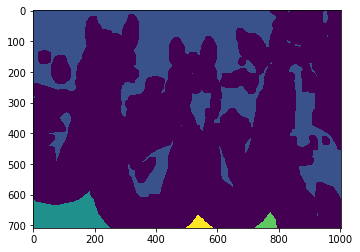

In [23]:
# Marker labelling
ret, marker = cv2.connectedComponents(fg)

# Add one to all labels so that bg is not  0, but 1
marker = marker+1

# Now, mark the region of unknown with 0
marker[unknown==255] = 0;

plt.imshow(marker)


Now we can run watershed over our image. Then we'll colour the segmentation boundaries the watershed found in green and save it.

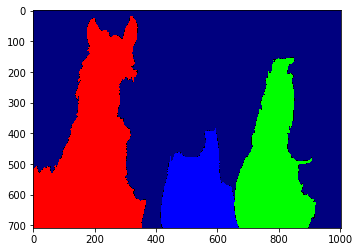

In [24]:
# Now marker is ready.  It is time for last step
cv2.watershed(im_arr, marker)

# Create a new empty image with the same shape
# as the original image.
h, w, num_c = im_arr.shape
seg = np.zeros((h, w, num_c), np.uint8)

# Watershed has replaced the pixel
# values in marker with integers representing
# the segments it has found in the original
# image.
# Color in these segments
# 
maxMarker = np.max(marker)
minMarker = np.min(marker)

colorMap =  [ \
             [0,0,0], \
             [255,255,255], \
             [127,0,0], \
             [0,0,255], \
             [0,255,0], \
             [255,0,0], \
             [255,255,0], \
             [255,0,255], \
             [127,0,127], \
             [127,127,127], \
             [0,255,255] \
            ]

for region in range(minMarker, maxMarker+1):
    seg[marker==region] = colorMap[region+1]
    
plt.imshow(cv2.cvtColor(seg, cv2.COLOR_BGR2RGB))


This method has identified the 3 horses but has lost the outline of them



# SLIC




In [0]:
from skimage import segmentation, color
from skimage.io import imread
from skimage.io import imsave

Run the SLIC super-pixel algorithm over the image, varying the compactness and the numsegments until the image you produce resembles the image below.

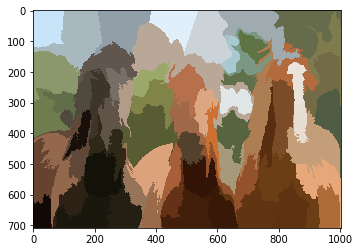

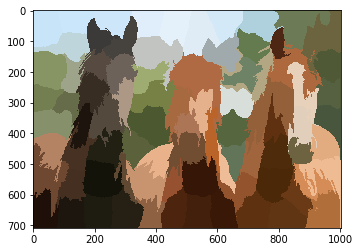

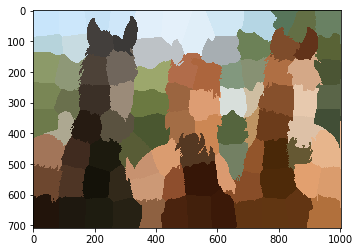

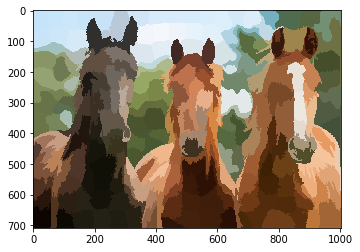

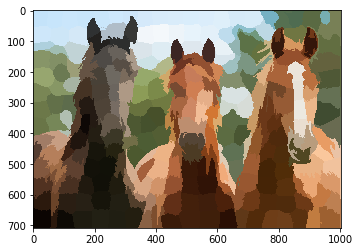

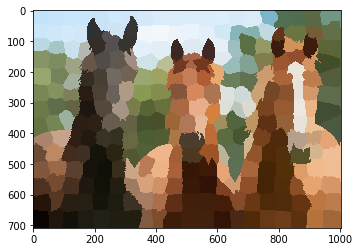

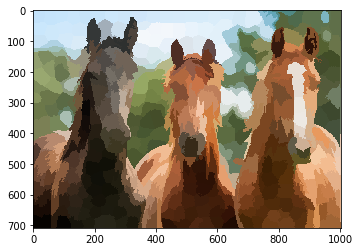

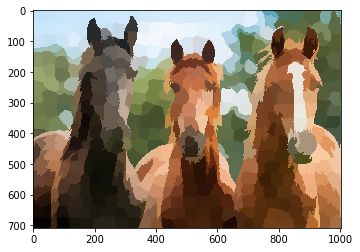

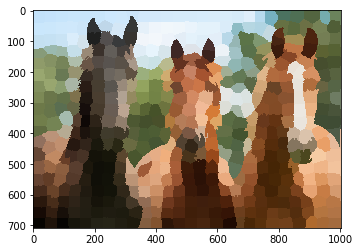

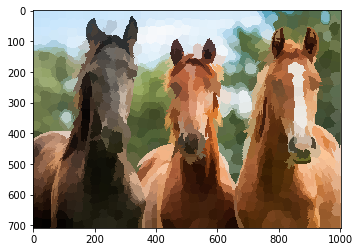

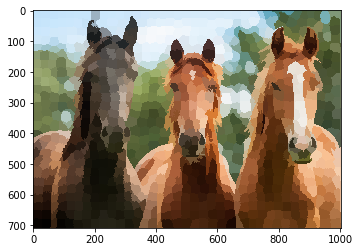

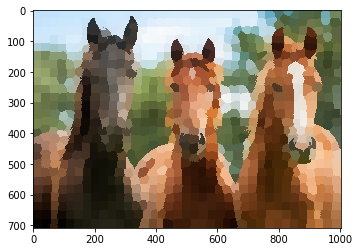

In [26]:
for numSegments in (100, 300, 500, 1000):
  for compactFactor in (10,20,50):
	  # apply SLIC and extract (approximately) the supplied number
	  # of segments
    segments = segmentation.slic(im_arr, compactness=compactFactor, n_segments = numSegments)
    superpixels = color.label2rgb(segments, im_arr, kind='avg')
    plt.imshow(superpixels)
    plt.show()


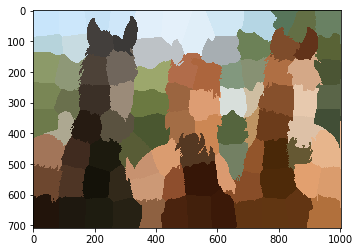

In [27]:
compactFactor = 50
numSegments = 100
img_segments = segmentation.slic(im_arr, compactness=compactFactor, n_segments=numSegments)
superpixels = color.label2rgb(img_segments, im_arr, kind='avg')

plt.imshow(superpixels)

In [28]:
len(np.unique(img_segments))

94

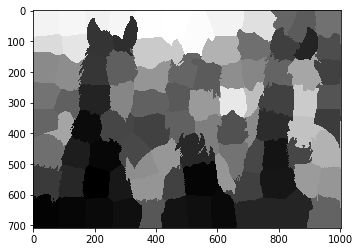

In [29]:
# Convert to grayscale so we can threshold it
gray = cv2.cvtColor(superpixels, cv2.COLOR_BGR2GRAY)
#m, thresh2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

m, thresh2 = cv2.threshold(gray,210,255,cv2.THRESH_BINARY_INV)

plt.imshow(gray, cmap='gray')

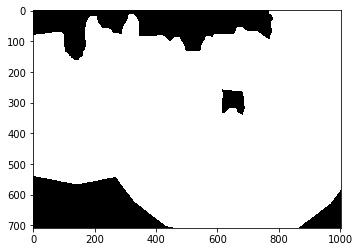

In [30]:

#  Close the image a little to fill in a few small holes in it
closingKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

# Create a matrix closed that is generated from thresh by a closing
# operation using the kernel above.
closed = cv2.morphologyEx(thresh2, cv2.MORPH_CLOSE, closingKernel)

# Use just enough dilate to get some clearly identifiable background
dilationKernel = np.ones((5,5), np.uint8)

# create a matrix 'bg' from OpenCV's dilate() function
# using the dilation kernel above
bg = cv2.dilate(closed, dilationKernel, iterations=3)

# Now use a distance transform to extract is clearly foreground

# Create a matrix 'dist_transform' using OpenCV's distanceTransform
# method on the 'closed' matrix.
dist_transform = cv2.distanceTransform(closed, cv2.DIST_L2, 5)

# Threshold the distance transformation
ret, fg = cv2.threshold(dist_transform,0.7*dist_transform.max(), 255, 0)

# Now find the unknown region by subtracting one from the other
fg = np.uint8(fg)
unknown = cv2.subtract(bg, fg)

plt.imshow(unknown, cmap='gray')

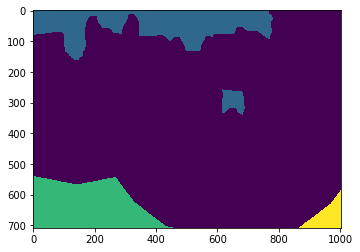

In [31]:
# Marker labelling
ret, marker = cv2.connectedComponents(fg)

# Add one to all labels so that bg is not  0, but 1
marker = marker+1

# Now, mark the region of unknown with 0
marker[unknown==255] = 0;

plt.imshow(marker)


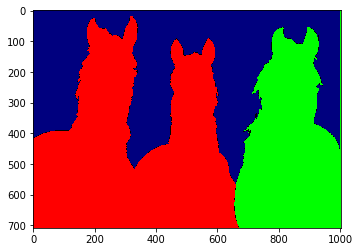

In [32]:
# Now marker is ready.  It is time for last step
cv2.watershed(im_arr, marker)

# Create a new empty image with the same shape
# as the original image.
h, w, num_c = im_arr.shape
seg = np.zeros((h, w, num_c), np.uint8)

# Watershed has replaced the pixel
# values in marker with integers representing
# the segments it has found in the original
# image.
# Color in these segments
# 
maxMarker = np.max(marker)
minMarker = np.min(marker)

colorMap =  [ \
             [0,0,0], \
             [255,255,255], \
             [127,0,0], \
             [0,0,255], \
             [0,255,0], \
             [255,0,0], \
             [255,255,0], \
             [255,0,255], \
             [127,0,127], \
             [127,127,127], \
             [0,255,255] \
            ]

for region in range(minMarker, maxMarker+1):
  seg[marker==region] = colorMap[region+1]
    
plt.imshow(cv2.cvtColor(seg, cv2.COLOR_BGR2RGB))
